In [28]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.3.1+cu121
0.18.1+cu121


In [29]:
import os
import flwr as fl
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from opacus import PrivacyEngine
from collections import OrderedDict

from flwr.common import NDArrays, Scalar
from typing import Dict, Optional, Tuple
from typing import List

import pydicom
import rarfile
import zipfile
import pydicom
from PIL import Image
import math, json, os, sys

from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
import seaborn as sns
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from art.attacks.inference.membership_inference import MembershipInferenceBlackBox
from art.estimators.classification.pytorch import PyTorchClassifier
from torchvision import datasets, transforms, models

In [30]:
zip_path = 'rsna-pneumonia-detection-challenge.zip'
extract_path = 'rsna-pneumonia-detection-challenge'
#with zipfile.ZipFile(zip_path, 'r') as zf:
#    zf.extractall(extract_path)
train_images_path = os.path.join(extract_path, 'stage_2_train_images')
labels_csv_path = os.path.join(extract_path, 'stage_2_train_labels.csv')
labels_df = pd.read_csv(labels_csv_path)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

def extract_features(img):  
    pixel_array = np.array(img)
    return pixel_array
def conv_dcm_img(dicom_path):
    dicom = pydicom.dcmread(dicom_path)
    pixel_array = dicom.pixel_array
    image = Image.fromarray(pixel_array)
    return image
feature_vectors = []
labels = []
for index, row in labels_df.iterrows():
    dicom_id = row['patientId']
    label = row['Target']
    dicom_path = os.path.join(train_images_path, f"{dicom_id}.dcm")    
    if os.path.exists(dicom_path): 
        image=transform(conv_dcm_img(dicom_path))
        feature_vector = extract_features(image)
        feature_vectors.append(feature_vector)
        labels.append(label)
        if index%100==0:
            print(index)
            if index>4000:
                break

X = np.array(feature_vectors)
y = np.array(labels)
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)
#print(X_scaled.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=150)
print(f'Training data shape: {X_train.shape}')
print(f'Testing data shape: {X_test.shape}')
print(f'Training labels shape: {y_train.shape}')
print(f'Testing labels shape: {y_test.shape}')


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
Training data shape: (3280, 3, 224, 224)
Testing data shape: (821, 3, 224, 224)
Training labels shape: (3280,)
Testing labels shape: (821,)


In [31]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)  
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)   

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [32]:
class GNResNet(nn.Module):
    def __init__(self, original_resnet, num_groups=32):
        super(GNResNet, self).__init__()
        self.model = original_resnet
        self.num_groups = num_groups
        self._replace_batchnorm_with_groupnorm(self.model)

    def _replace_batchnorm_with_groupnorm(self, module):
        for name, child in module.named_children():
            if isinstance(child, nn.BatchNorm2d):
                num_channels = child.num_features
                setattr(module, name, nn.GroupNorm(self.num_groups, num_channels))
            elif isinstance(child, nn.Sequential) or isinstance(child, nn.Module):
                self._replace_batchnorm_with_groupnorm(child)

    def forward(self, x):
        return self.model(x)

original_resnet = models.resnet50(pretrained=True)
num_classes = 2
original_resnet.fc = nn.Linear(original_resnet.fc.in_features, num_classes)

model = GNResNet(original_resnet, num_groups=32)

model = model.to(device)

# Set up the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

privacy_engine = PrivacyEngine()
# Set privacy parameters
model, optimizer, train_loader = privacy_engine.make_private(
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    noise_multiplier=0.1,
    max_grad_norm=1.0,
  )
#epsilon, best_alpha = privacy_engine.get_epsilon(delta=1e-5)
#print(f"ε = {epsilon:.2f}, δ = {1e-5}")

/home/dgxuser49/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dgxuser49/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/dgxuser49/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


In [33]:
checkpoint_dir = 'DP-CNN_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
f2.write(f"Epoch,Loss,Accuracy,Val_Loss,Val_Accuracy\n")
f2.write(f"Round,Loss,Accuracy\n")

20

In [34]:
def train(model, train_loader, epochs=35):
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        model = model.to(device)
        model.train()
        for data, target in train_loader:
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            print(f"Loss:{loss}")
            loss.backward()
            optimizer.step()
            epoch_loss += loss
            total += target.size(0)
            correct += (torch.max(outputs.data, 1)[1] == target).sum().item()
        epoch_loss /= len(train_loader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss:.8f}, accuracy {epoch_acc}")
        #f = open("train_DPRES_xray_35_1.txt", "a")
        #f.write(f"Epoch: {epoch+1} Loss: {epoch_loss:.8f}, Accuracy: {epoch_acc:.8f}\n")
        #f.close()
        test_correct, test_total, test_loss = 0, 0, 0

        with torch.no_grad():
            for test_data, test_target in test_loader:
                test_data = test_data.to(device)
                test_target = test_target.to(device)
                test_outputs = model(test_data)
                test_loss += criterion(test_outputs, test_target).item()
                _, test_predicted = torch.max(test_outputs.data, 1)
                test_total += test_target.size(0)
                test_correct += (test_predicted == test_target).sum().item()
        test_loss /= len(test_loader.dataset)
        test_accuracy = test_correct / test_total
        print(f'Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}')
        #f1 = open("test_DPRES_xray_35_1.txt", "a")
        #f1.write(f"Loss: {test_loss:.8f}, Accuracy: {test_accuracy:.8f}\n")
        #f1.close()
        #f2.write(f"{epoch+1},{epoch_loss:.8f},{epoch_acc:.8f},{test_loss:.4f},{test_accuracy:.8f}\n")
    #f2.close()
    return model
 

In [7]:
trained_model = train(model, train_loader, epochs=35)
# Save model checkpoint
checkpoint_path = os.path.join(checkpoint_dir, f'DPRES_epoch_35_1.pth')
torch.save(trained_model, checkpoint_path)
print(f"Model checkpoint saved at {checkpoint_path}")

/home/dgxuser49/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Loss:0.963748574256897
Loss:1.3905048370361328
Loss:3.127338171005249
Loss:3.208850860595703
Loss:1.8317710161209106
Loss:0.7292203307151794
Loss:1.006975531578064
Loss:2.3802497386932373
Loss:1.275465488433838
Loss:3.9004008769989014
Loss:2.0421388149261475
Loss:1.0351916551589966
Loss:1.6405189037322998
Loss:1.833845615386963
Loss:3.0588884353637695
Loss:2.6340458393096924
Loss:2.49013352394104
Loss:1.9250516891479492
Loss:1.1186401844024658
Loss:0.6705887913703918
Loss:2.2042670249938965
Loss:2.461819648742676
Loss:2.3765289783477783
Loss:1.8254649639129639
Loss:1.4946045875549316
Loss:2.4033043384552
Loss:1.3555545806884766
Loss:1.1662052869796753
Loss:1.2337526082992554
Loss:2.320891857147217
Loss:2.401381492614746
Loss:2.658418655395508
Loss:1.7296534776687622
Loss:1.9510642290115356
Loss:1.9131755828857422
Loss:1.0356119871139526
Loss:0.9427358508110046
Loss:1.4264311790466309
Loss:1.8042148351669312
Loss:1.9707858562469482
Loss:1.795213222503662
Loss:2.6027016639709473
Loss:1.3

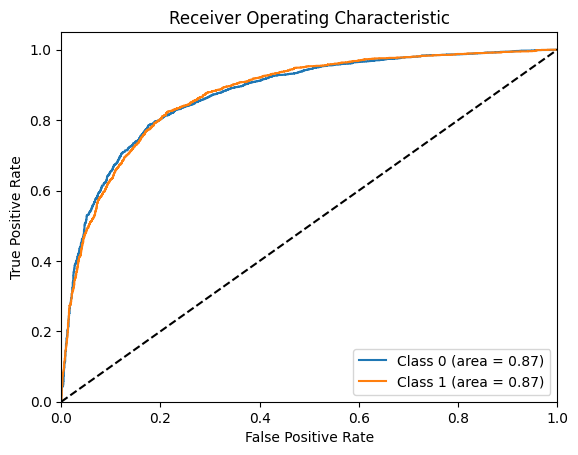

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      4143
           1       0.69      0.73      0.71      1903

    accuracy                           0.81      6046
   macro avg       0.78      0.79      0.78      6046
weighted avg       0.81      0.81      0.81      6046



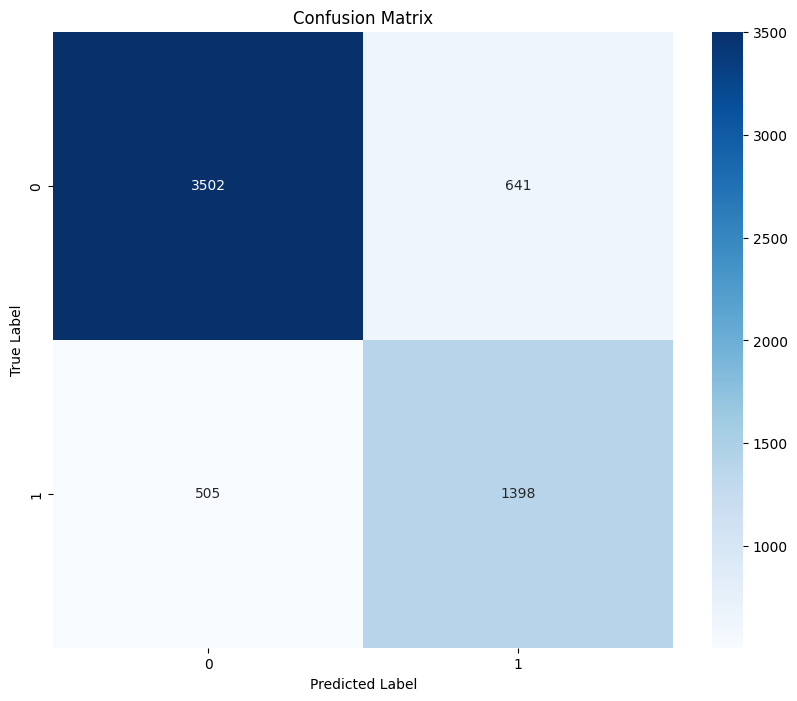

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import seaborn as sns

class GNResNet(nn.Module):
    def __init__(self, original_resnet, num_groups=32):
        super(GNResNet, self).__init__()
        self.model = original_resnet
        self.num_groups = num_groups
        self._replace_batchnorm_with_groupnorm(self.model)

    def _replace_batchnorm_with_groupnorm(self, module):
        for name, child in module.named_children():
            if isinstance(child, nn.BatchNorm2d):
                num_channels = child.num_features
                setattr(module, name, nn.GroupNorm(self.num_groups, num_channels))
            elif isinstance(child, nn.Sequential) or isinstance(child, nn.Module):
                self._replace_batchnorm_with_groupnorm(child)

    def forward(self, x):
        return self.model(x)
if __name__ == "__main__":
    checkpoint_path = os.path.join(checkpoint_dir, f'DPRES_epoch_35_1.pth')
    RES_CNN_model =torch.load(checkpoint_path)

    RES_CNN_model = RES_CNN_model.to(device)
    RES_CNN_model.eval()
    
    # Initialize lists to store true labels and predictions
    true_labels = []
    pred_probs = []
    
    # Make predictions
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = RES_CNN_model(images)
            probabilities = torch.softmax(outputs, dim=1)
            pred_probs.extend(probabilities.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    true_labels = np.array(true_labels)
    pred_probs = np.array(pred_probs)
    pred_labels = np.argmax(pred_probs, axis=1)
    
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(true_labels == i, pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure()
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    class_names=['0','1']
    print(classification_report(true_labels, pred_labels, target_names=class_names))
    
    conf_matrix = confusion_matrix(true_labels, pred_labels)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

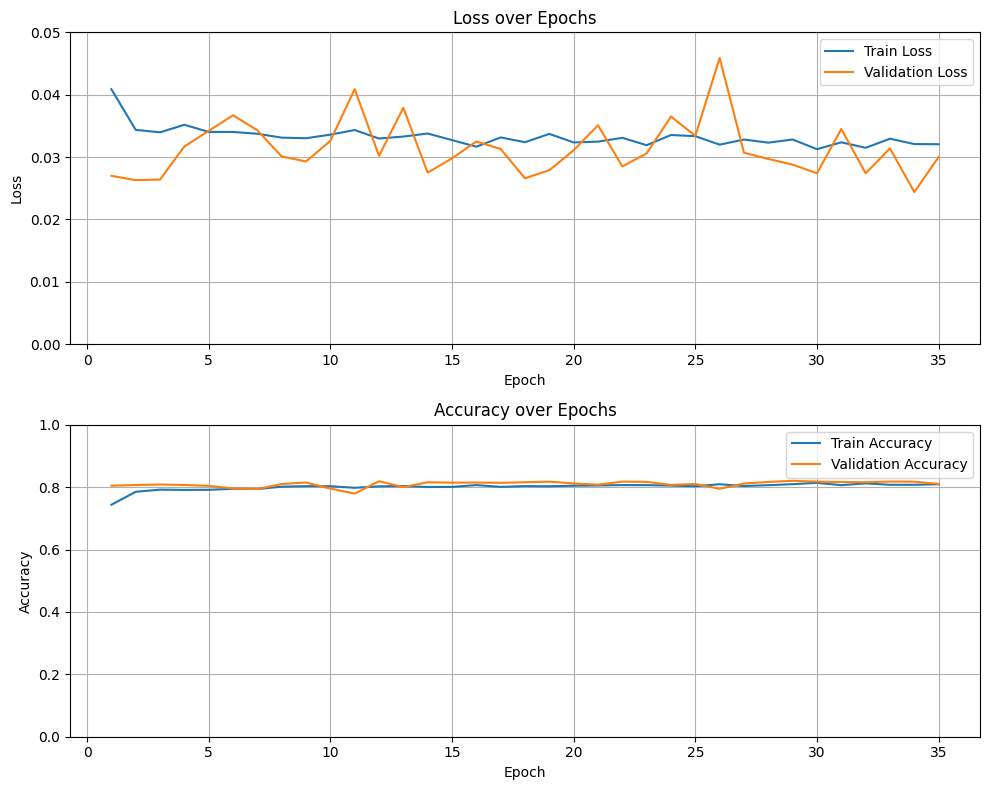

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
file_path = 'DP-RESNET-1.csv'  # Replace with the actual path to your CSV file
data = pd.read_csv(file_path)

# Extract relevant columns
epochs = data['Epoch']
train_loss = data['Loss']
train_accuracy = data['Accuracy']
val_loss = data['Val_Loss']
val_accuracy = data['Val_Accuracy']

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot loss values
ax1.plot(epochs, train_loss, label='Train Loss')
ax1.plot(epochs, val_loss, label='Validation Loss')
ax1.set_ylim([0.0, 0.05])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss over Epochs')
ax1.legend()
ax1.grid(True)

# Plot accuracy values
ax2.plot(epochs, train_accuracy, label='Train Accuracy')
ax2.plot(epochs, val_accuracy, label='Validation Accuracy')
ax2.set_ylim([0.0, 1.0])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy over Epochs')
ax2.legend()
ax2.grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()
